## Assignment 1: Study on building energy consumption

This notebook presents a study on building energy consumption in which we try to find an answer to the question "can we measure and predict energy use based on observables that are easier to be acquired". The study attempts to answer the question by using the number of units on the building.

The data that will be used is comming both from the NYC open data portal and the Pluto dataset

The notebook reuses a big portion of the data acquisition, transformations and plotting logic from fedheres skeleton notebook for HW4 (https://github.com/fedhere/PUI2016_fb55/blob/master/HW4_fb55/citibikes_compare_distributions.ipynb)

In [94]:
# Standard imports to work with datasets, plots, etc.
import pylab as pl
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import requests
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import *

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)

url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
pl.rcParams.update(data)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['polyint', 'griddata', 'insert']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [200]:
# Acquire and prepare the data

# Download the Energy and Water Data Disclosure for Local Law 84 (2013) dataset
# os.system("curl https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD > energyDisclosure.csv")
# os.system("mv " + "energyDisclosure.csv " + os.getenv("PUIDATA"))

# Or we can actually load it directly on a dataframe if we have access to the internet
nrg = pd.read_csv("https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv")
nrg.head(2)

,Record Number,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0


In [122]:
# Download the manhattan pulto shape file
# Created a MNMapPluto folder under PUIData to put all the Pluto Files

# First get the full Pluto Package from nyc.gove
os.system("curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip")

# Unzip the files and move to the MNMapPluto subfolder (they all start with MN)
os.system("unzip -jn mn_mappluto_16v1.zip MN*")
os.system("mv " + "MN* " + os.getenv("PUIDATA") + "/MNMapPluto")

# Read the Manhattan SHP file that was obtained from the PLUTO dataset
bsize = gpd.read_file (os.getenv("PUIDATA") + "/MNMapPluto/MNMapPLUTO.shp")
bsize.head(2)

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.000000e+00,None,1592 2 AVENUE,C1-9/TA,None,2,468000.0,1435950.0,1.015450e+09,10885,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,1.007230e+09,11/30/2006,263 9 AVENUE,C1-5/R8,None,2,539984.0,11879993.0,1.007238e+09,89203,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."


In [201]:
# The SHP file obtained from the PLUTO dataset seems to contain only the geometry (no other data)
# Will use the NYC Pluto data donwloader (http://chriswhong.github.io/plutoplus/#) to enerate a CSV with the data
# and upload it to my PUIDATA directory

# Complete version
# bsize = pd.read_csv (os.getenv("PUIDATA") + "/PlutoManhattan.csv")

# Only necessary columns (BBL, Units)
# bsize = pd.read_csv (os.getenv("PUIDATA") + "/plutoManhattanMin.csv")
# bsize.head(2)
bsize.columns

Index([u'BBL', u'UnitsRes', u'UnitsTotal'], dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f6891fcd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0f6d302050>]], dtype=object)

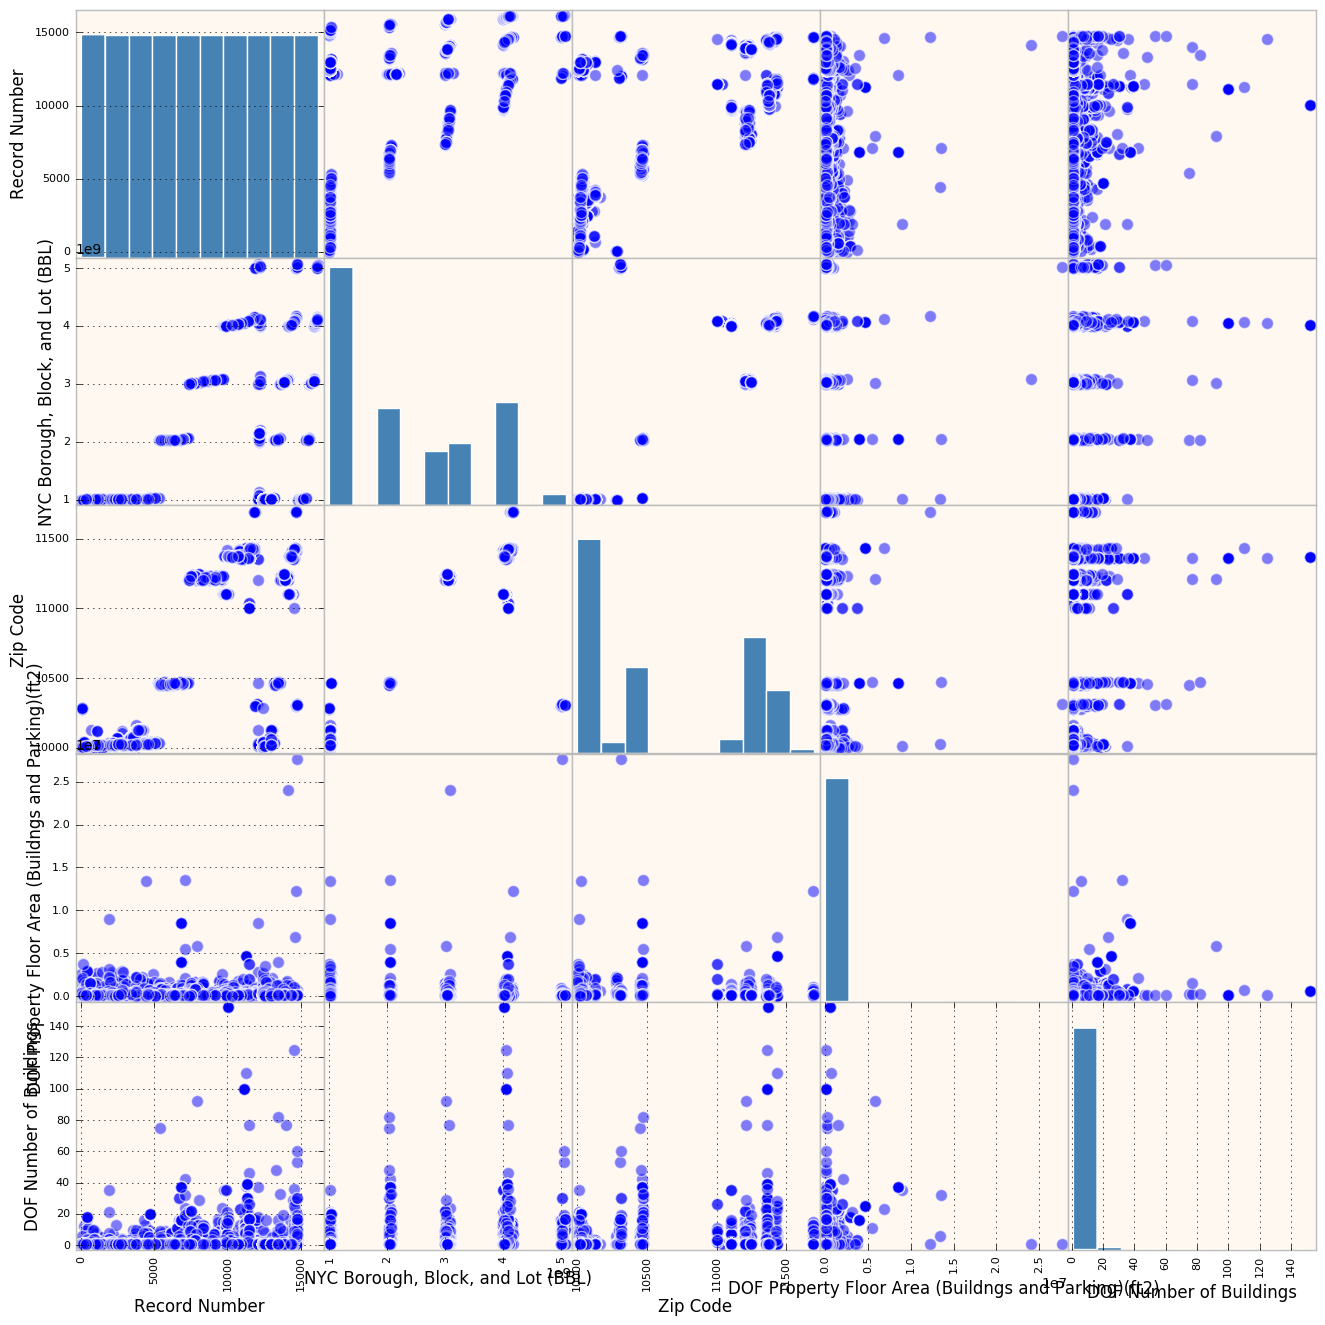

In [202]:
#nrg scatterplot: explore the data, see which columns do not plot
scatter_matrix (nrg, s=300, figsize=(16, 16))

In [204]:
# Data Cleanup

# Clean function and procedure from the Original FBB's skeleton notebook
# https://github.com/fedhere/PUI2016_fb55/blob/master/HW6_fb55/building_nrg_instructions.ipynb
# To obtain array of booleans used later to filter out those rowns in which the conversion failed

def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
    

# Select the columns needed from nrg
nrg = nrg[['NYC Borough, Block, and Lot (BBL)', 'Site EUI(kBtu/ft2)', \
           'Reported Property Floor Area (Building(s)) (ft²)']]

# Select the comlumns needed from bsize
bsize = bsize[['BBL', 'UnitsRes', 'UnitsTotal']]

nrg.head()

# Cleanup Columns from nrg
indx = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['Site EUI(kBtu/ft2)'][~indx] = float('NaN')

indx = (np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft²)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx] = float('NaN')

nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor \
Area (Building(s)) (ft²)'], errors='coerce')

nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')

#Avoid problem with the column name (because of non ASCI Char)
nrg=nrg.rename(columns = {'Reported Property Floor Area (Building(s)) (ft²)':'Floor Area(ft2)'})

nrg.columns
nrg.head()

invalid entries changed to NaN 15513
invalid entries changed to NaN 15430


,"NYC Borough, Block, and Lot (BBL)",Site EUI(kBtu/ft2),Floor Area(ft2)
0,1.000410e+09,NaN,918919.0
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200.0
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000.0


,BBL,Site EUI(kBtu/ft2),Floor Area(ft2),UnitsRes,UnitsTotal
0,1.006700e+09,NaN,NaN,0,1
1,1.004370e+09,NaN,NaN,0,4
2,1.013110e+09,125.4,330000.0,0,56
3,1.009220e+09,NaN,NaN,148,148
4,1.007400e+09,NaN,68329.0,0,1


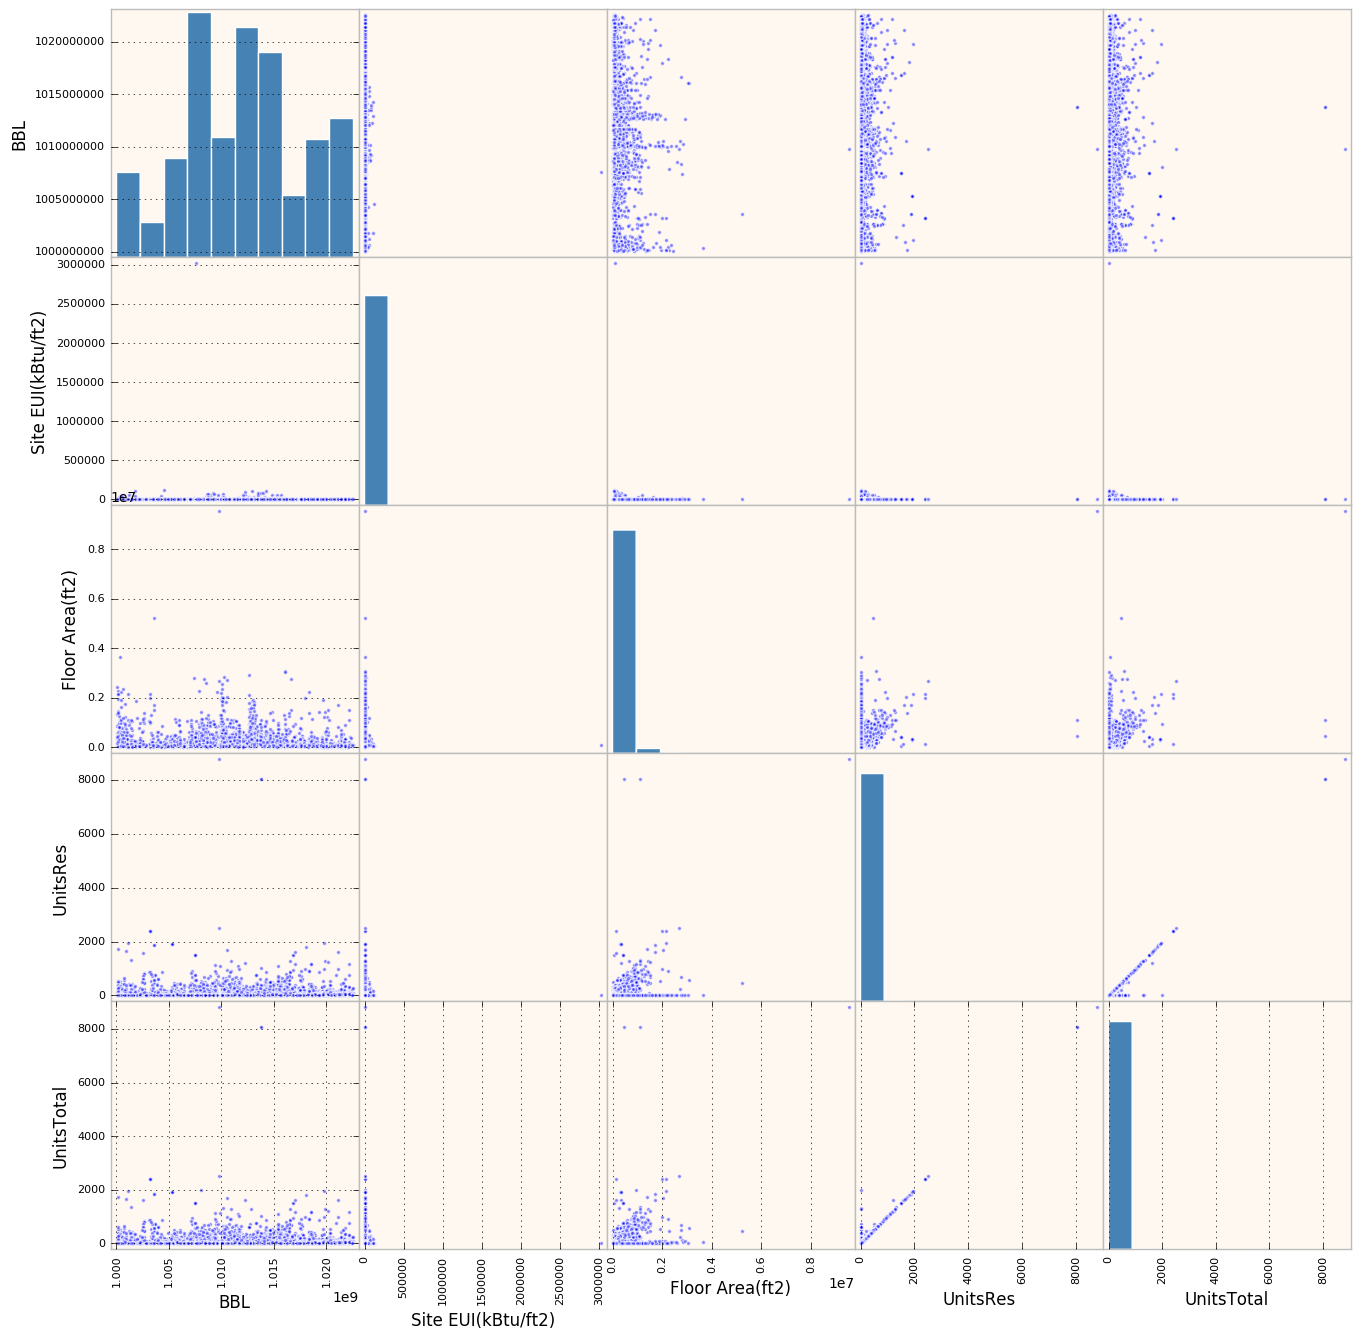

In [218]:
# Merge the dataframes

# prepare the join index colum in nrg (rename to bbl)
nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)': 'BBL'}, inplace=True)

#merge
bblnrgdata = pd.merge(nrg, bsize, on='BBL')

# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16))
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Floor Area(ft2),UnitsRes,UnitsTotal,Energy Total,EnergyTotal,EnergyTotalLog,UnitsTotalLog
2,1.013110e+09,125.4,330000.0,0,56,41382000.0,41382000.0,7.616811,1.748188
10,1.010140e+09,154.9,841709.0,0,2,130380724.1,130380724.1,8.115213,0.301030
15,1.007660e+09,122.3,59468.0,0,8,7272936.4,7272936.4,6.861710,0.903090
16,1.008150e+09,117.0,364000.0,0,24,42588000.0,42588000.0,7.629287,1.380211
18,1.005050e+09,82.1,235370.0,0,24,19323877.0,19323877.0,7.286094,1.380211


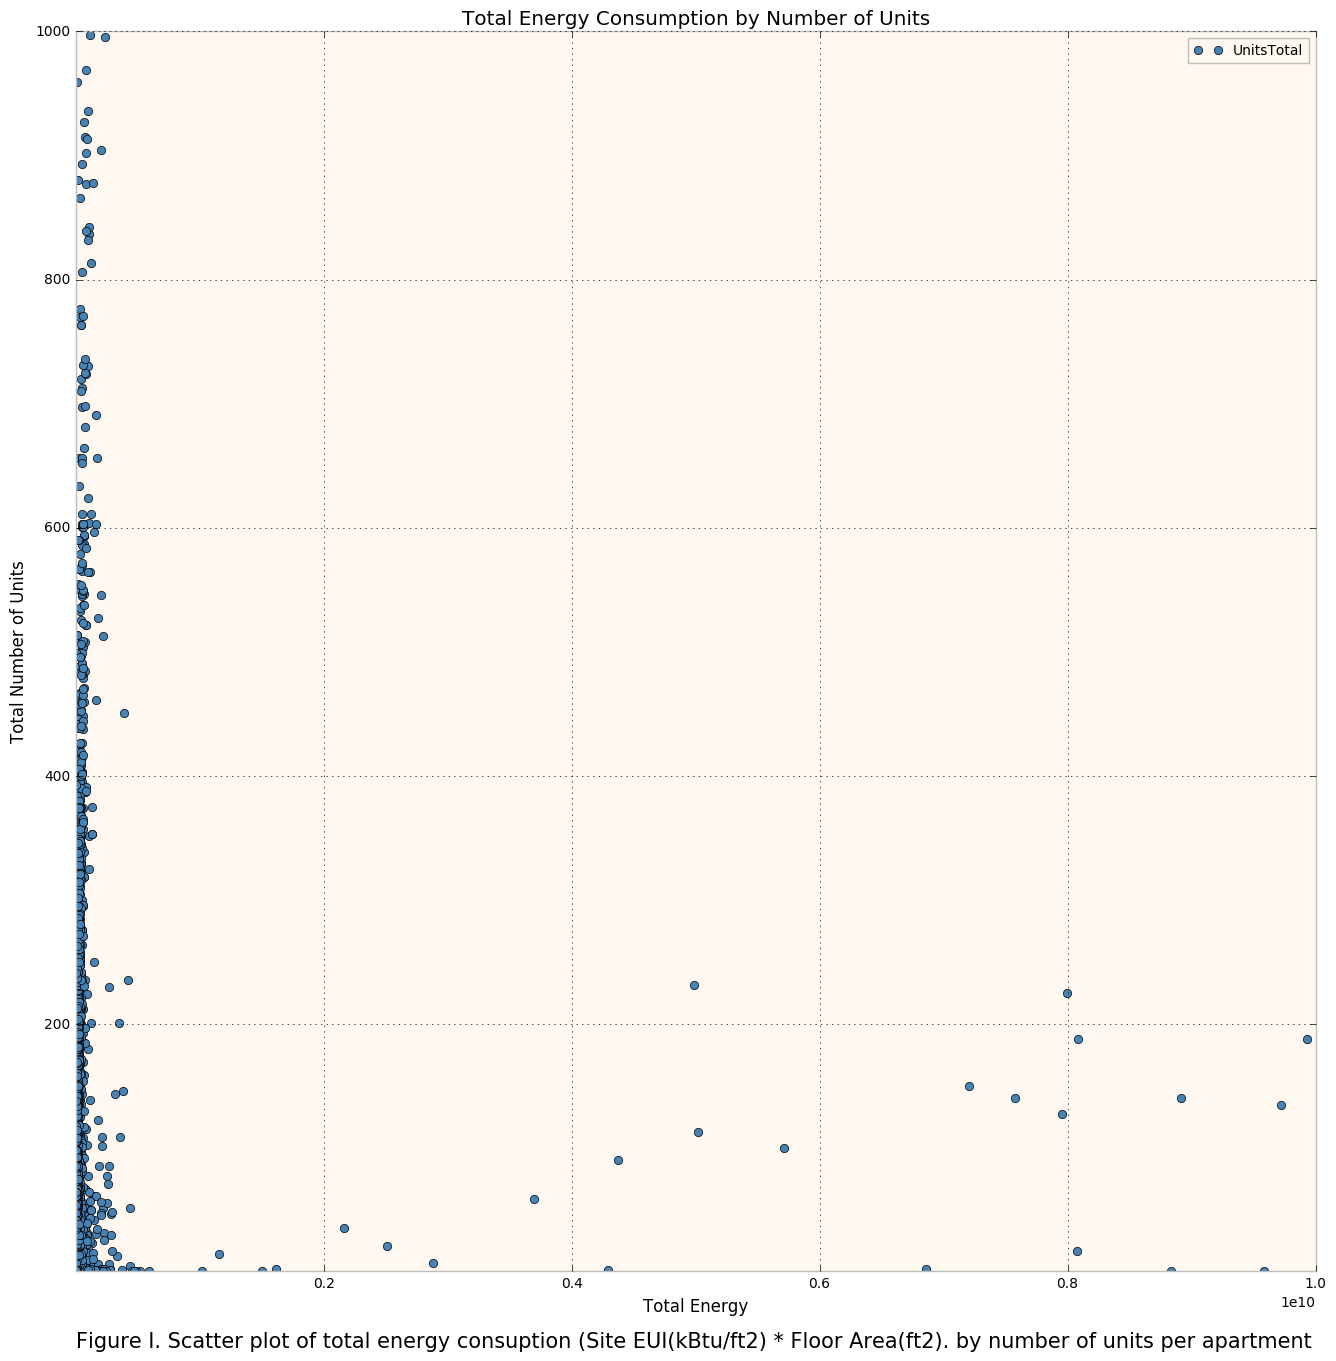

In [341]:
# Data Cleaning #2
# On our model the value 0 on both the number of units or the energy consumption are either wrong or meaningless
# So we will remove them. We also take FBB's consideration in terms of sensible energe threshold

bblnrgdata['EnergyTotal'] = bblnrgdata['Site EUI(kBtu/ft2)'] *  bblnrgdata['Floor Area(ft2)']

bblnrgdata['EnergyTotalLog'] = np.log10(bblnrgdata['EnergyTotal'])
bblnrgdata['UnitsTotalLog'] = np.log10(bblnrgdata['UnitsTotal'])

bblnrgdata = bblnrgdata[((bblnrgdata['EnergyTotal'] >= 1000) & (bblnrgdata.UnitsTotal != 0) )]

#bblnrgdata.plot(x='Site EUI(kBtu/ft2)', y='UnitsTotal', style='o',xlim=(1000,1e10), ylim=(1,1000))

# print(bblnrgdata['Site EUI(kBtu/ft2)'].min())
# print (bblnrgdata['Site EUI(kBtu/ft2)'].max())

bblnrgdata.plot(x='EnergyTotal', y='UnitsTotal', style='o', figsize=(16, 16),xlim=(1000,1e10), ylim=(1,1000))
pl.ylabel("Total Number of Units")
pl.xlabel("Total Energy")
pl.title('Total Energy Consumption by Number of Units')
pl.text(0, -60, "Figure I. Scatter plot of total energy consuption (Site EUI(kBtu/ft2) * Floor Area(ft2). \
by number of units per apartment", fontsize=15)

bblnrgdata.head()

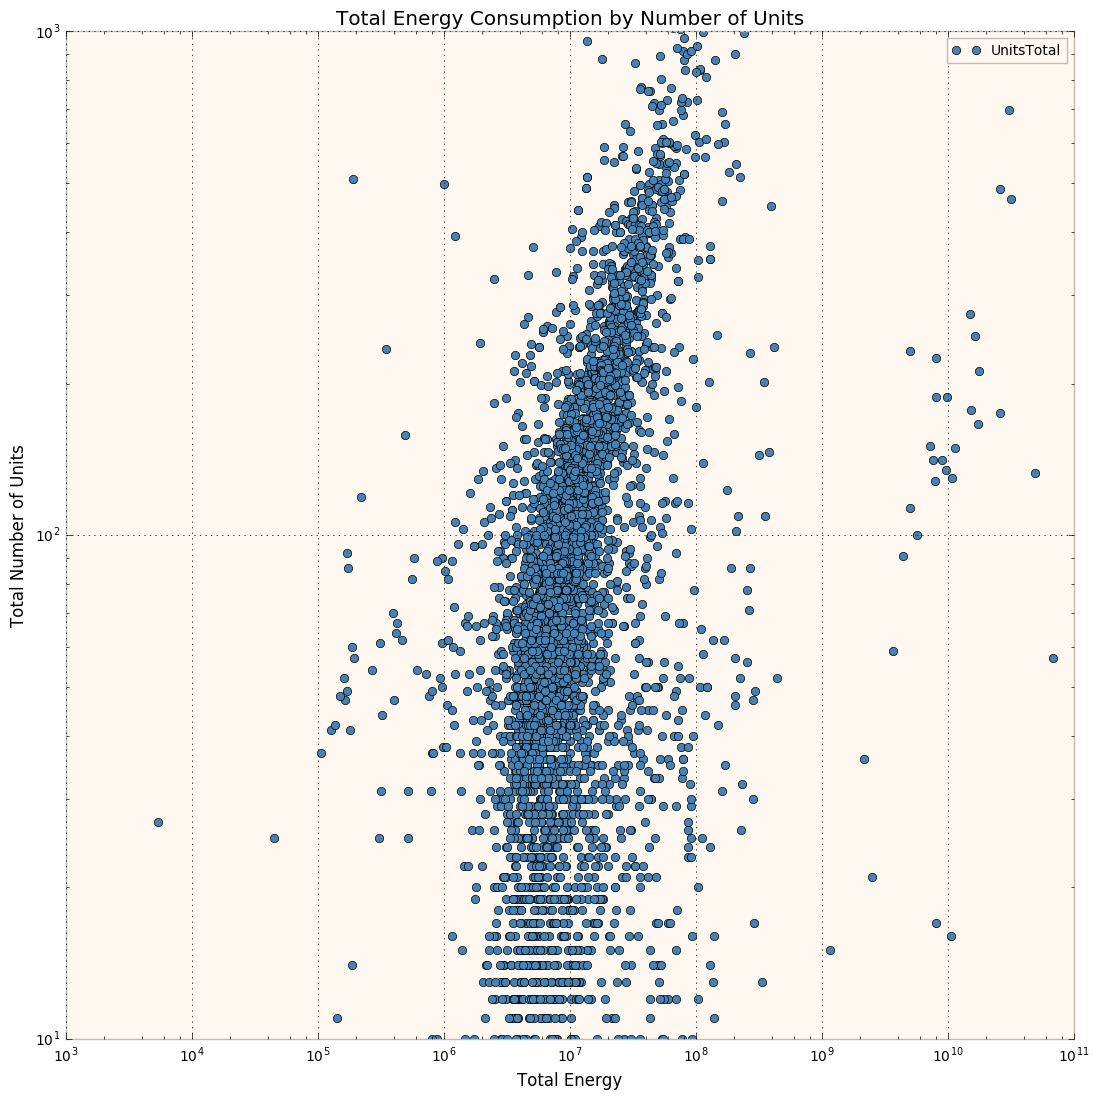

In [349]:
bblnrgdata.plot(x='EnergyTotal', y='UnitsTotal', style='o', figsize=(13, 13),xlim=(1000,1e11), ylim=(10,1000), 
                loglog= True)

pl.ylabel("Total Number of Units")
pl.xlabel("Total Energy")
pl.title('Total Energy Consumption by Number of Units')


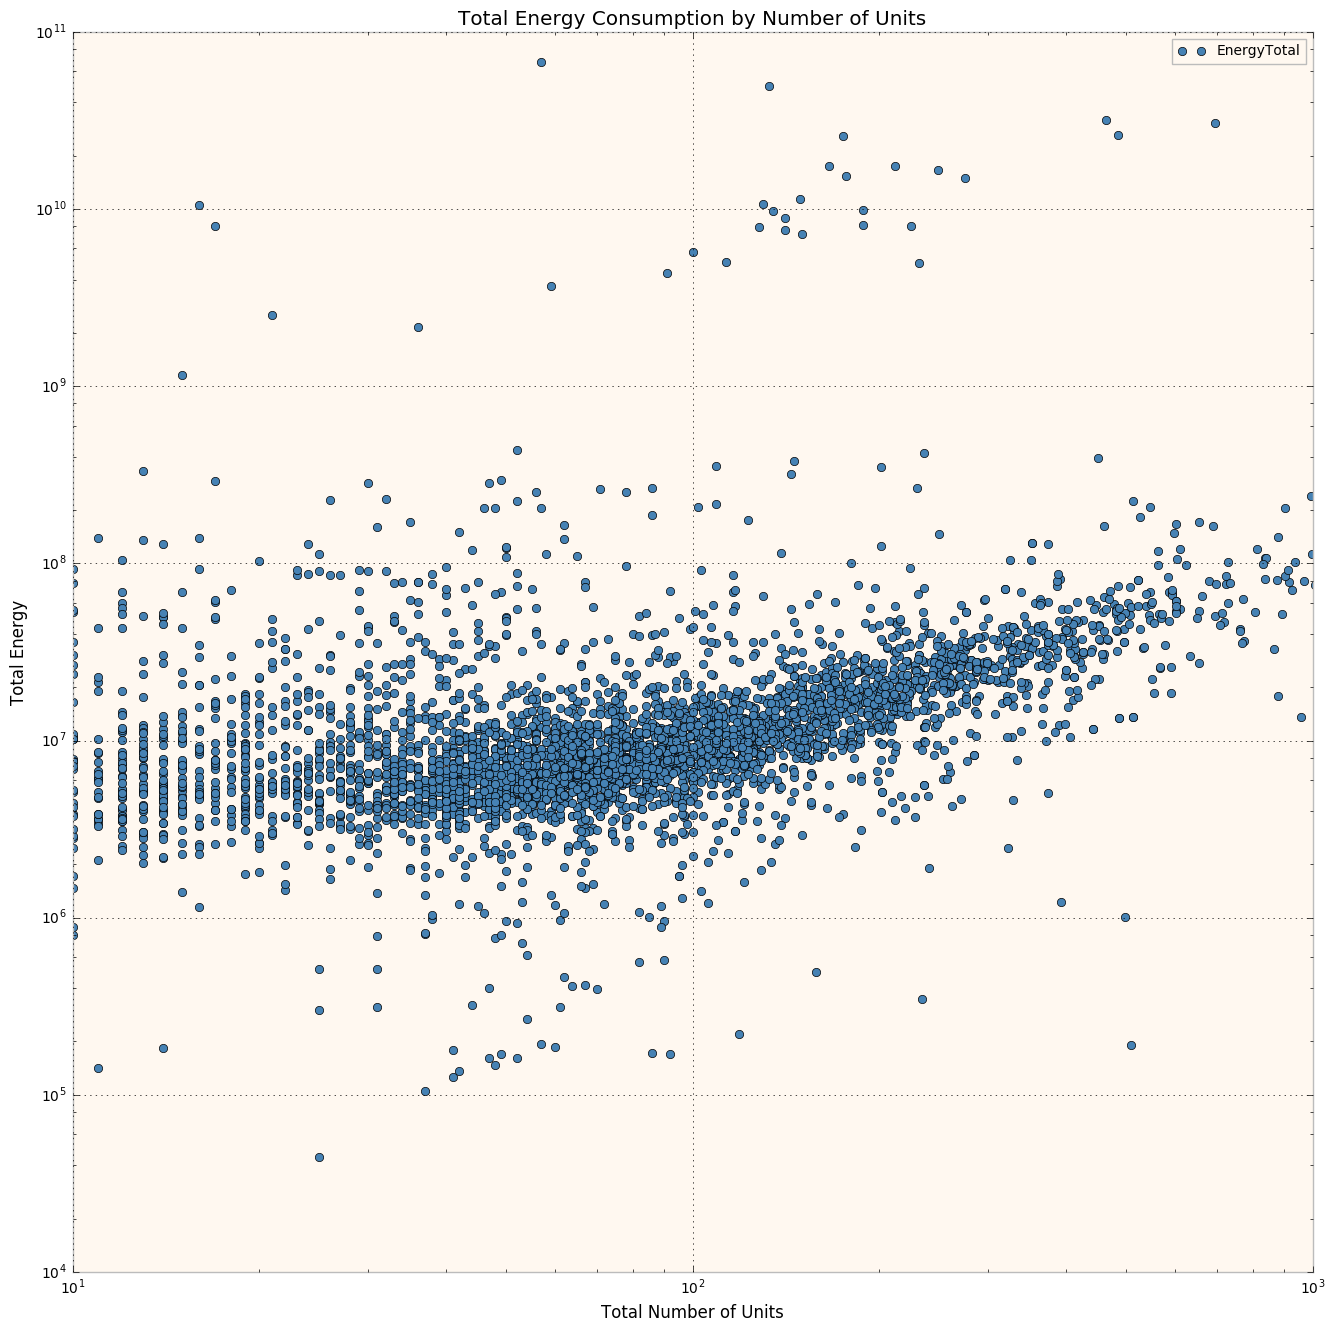

In [343]:
# Swapping Axis

bblnrgdata.plot(y='EnergyTotal', x='UnitsTotal', style='o', figsize=(16, 16),xlim=(10,1000), ylim=(10000,1e11), 
                loglog= True)
pl.xlabel("Total Number of Units")
pl.ylabel("Total Energy")
pl.title('Total Energy Consumption by Number of Units')

In [393]:
#aditional data cleanup: drop the 0 or value of energy total below 1000 as well for Units total that are 0
bblclean = bblnrgdata[(bblnrgdata['Energy Total']>=1000) & 
                      (bblnrgdata['UnitsTotal']>=3) & (bblnrgdata['UnitsTotal']<=2000)]
bblclean = bblclean.reset_index()

#modelfit1 is the linear model for Units vs Energy
statsenergy = sm.add_constant(bblclean['EnergyTotalLog'])
modelfit1 = sm.OLS(log10(bblclean['UnitsTotalLog']),statsenergy).fit()
modelfit1.params

bblclean['UnitsTotalPredict'] =( statsenergy['EnergyTotalLog'] * modelfit1.params[1] + modelfit1.params[0])

#Summary for the regression
modelfit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          UnitsTotalLog   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     191.9
Date:                Wed, 19 Oct 2016   Prob (F-statistic):           8.89e-43
Time:                        23:18:36   Log-Likelihood:                 2663.2
No. Observations:                4528   AIC:                            -5322.
Df Residuals:                    4526   BIC:                            -5310.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             -0.1509      0.029     -5.286      0.000        -0.207    -0.095
EnergyTotalLog     0.0560      0.004     13.854      0.000         0.048     0.064
==============================================================================
Omnibus:                     1773.329   Durbin-Watson:                   1.534
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7218.436
Skew:                          -1.923   Prob(JB):                         0.00
Kurtosis:                       7.845   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[]

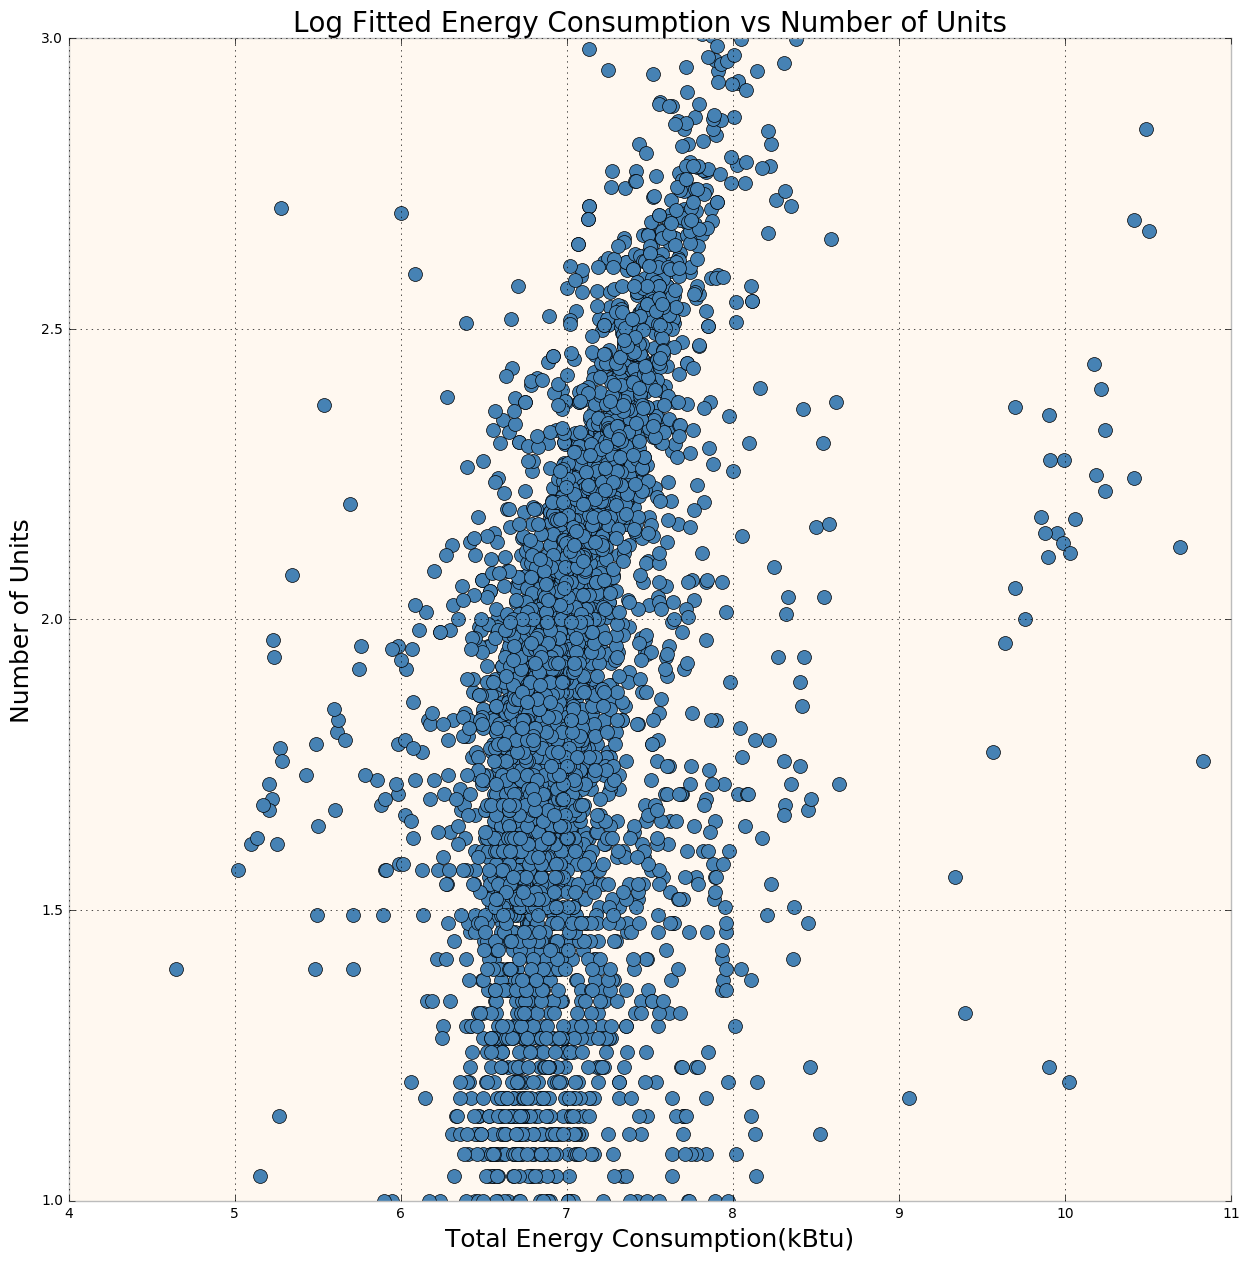

In [394]:
# Graph and fit

pl.figure(figsize = (15, 15))
#pl.set_xlim = ([1000, 1e10])
#pl.set_ylim = ([1, 1000])
pl.plot(bblclean['EnergyTotalLog'], bblclean['UnitsTotalLog'], 'o', ms = 10)
pl.plot(bblclean['EnergyTotalLog'], bblclean['UnitsTotalPredict'], color='k')
pl.title('Log Fitted Energy Consumption vs Number of Units', size = 20)
pl.ylabel('Number of Units', size = 18)
pl.xlabel('Total Energy Consumption(kBtu)', size = 18)
plt.xlim(log10(10000), log10(1e11))
plt.ylim(log10(10), log10(1000))
pl.plot()

In [404]:
#Change axis: 
statsunit = sm.add_constant(bblclean['UnitsTotalLog'])
modelfit2 = sm.OLS(bblclean['EnergyTotalLog'],statsunit).fit()
modelfit2.params

bblclean['EnergyTotalPredict'] =( statsunit['UnitsTotalLog'] * modelfit2.params[1] + modelfit2.params[0])

modelfit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         EnergyTotalLog   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     425.2
Date:                Wed, 19 Oct 2016   Prob (F-statistic):           2.32e-90
Time:                        23:22:10   Log-Likelihood:                -3028.0
No. Observations:                4528   AIC:                             6060.
Df Residuals:                    4526   BIC:                             6073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             6.4865      0.028    233.913      0.000         6.432     6.541
UnitsTotalLog     0.3025      0.015     20.620      0.000         0.274     0.331
==============================================================================
Omnibus:                     2284.815   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36830.560
Skew:                           2.017   Prob(JB):                         0.00
Kurtosis:                      16.377   Cond. No.                         9.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[]

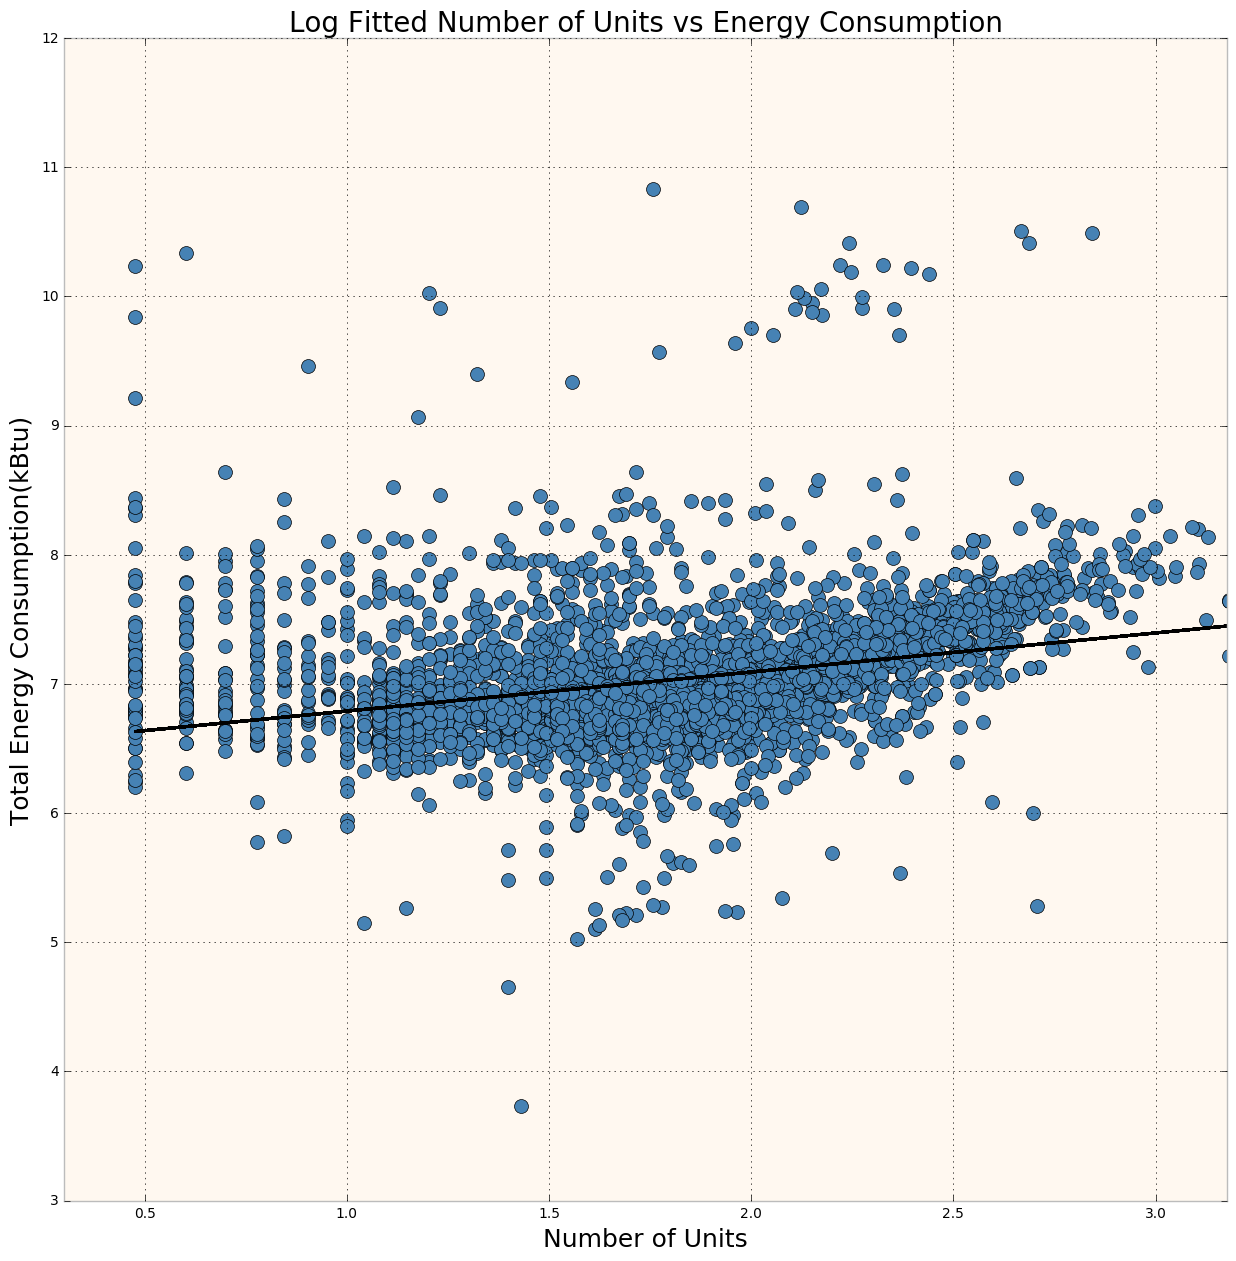

In [401]:
pl.figure(figsize = (15, 15))
#pl.set_xlim = ([1000, 1e10])
#pl.set_ylim = ([1, 1000])
pl.plot(bblclean['UnitsTotalLog'],bblclean['EnergyTotalLog'], 'o', ms = 10)
pl.plot(bblclean['UnitsTotalLog'], bblclean['EnergyTotalPredict'], color='k')
pl.title('Log Fitted Number of Units vs Energy Consumption', size = 20)
pl.xlabel('Number of Units', size = 18)
pl.ylabel('Total Energy Consumption(kBtu)', size = 18)
plt.ylim(log10(1000), log10(1e12))
plt.xlim(log10(2), log10(1500))
pl.plot()
#ylim=(10000,1e11), xlim=(10,1000)

In [417]:
# Calculating the chisq value for each of the models

# Energy Total vs Units Total
residual1 = (bblclean.UnitsTotalPredict - bblclean['UnitsTotalLog'])**2
error1 = ((bblclean['UnitsTotalLog']))
chisq1 = residual1 / error1
print ("Chisq value for Energy Total vs Units Total " + str(chisq1.sum()))

## Units Total vs Energy Total 
residual2 = bblclean.EnergyTotalPredict - bblclean['EnergyTotalLog']**2
error2 = ((bblclean['EnergyTotalLog']))
chisq2 = residual2 / error2
print ("Chisq value for Units Total vs Energy Total  " + str(chisq2.sum()))

bblclean.head()

Chisq value for Energy Total vs Units Total 6238.50314295
Chisq value for Units Total vs Energy Total  -27328.8881351


,index,BBL,Site EUI(kBtu/ft2),Floor Area(ft2),UnitsRes,UnitsTotal,Energy Total,EnergyTotal,EnergyTotalLog,UnitsTotalLog,UnitsTotalPredict,EnergyTotalPredict
0,2,1.013110e+09,125.4,330000.0,0,56,41382000.0,41382000.0,7.616811,1.748188,0.275849,7.015354
1,15,1.007660e+09,122.3,59468.0,0,8,7272936.4,7272936.4,6.861710,0.903090,0.233547,6.759721
2,16,1.008150e+09,117.0,364000.0,0,24,42588000.0,42588000.0,7.629287,1.380211,0.276548,6.904045
3,18,1.005050e+09,82.1,235370.0,0,24,19323877.0,19323877.0,7.286094,1.380211,0.257322,6.904045
4,19,1.021420e+09,137.7,64806.0,54,62,8923786.2,8923786.2,6.950549,1.792392,0.238524,7.028725


In [424]:
bblclean['logsquaredunitotal'] = bblclean['UnitsTotalLog']**2
bblclean.head(10)

#Fit the 

curvemodel = smf.ols(formula='EnergyTotalLog ~ UnitsTotalLog + logsquaredunitotal', data = bblclean).fit()
curvemodel.params

Intercept             7.821746
UnitsTotalLog        -1.354289
logsquaredunitotal    0.474248
dtype: float64

In [426]:
bblclean['energypredict2d']=curvemodel.predict(bblclean)
bblclean.head(10)
x = linspace(0,3.5,100)

[]

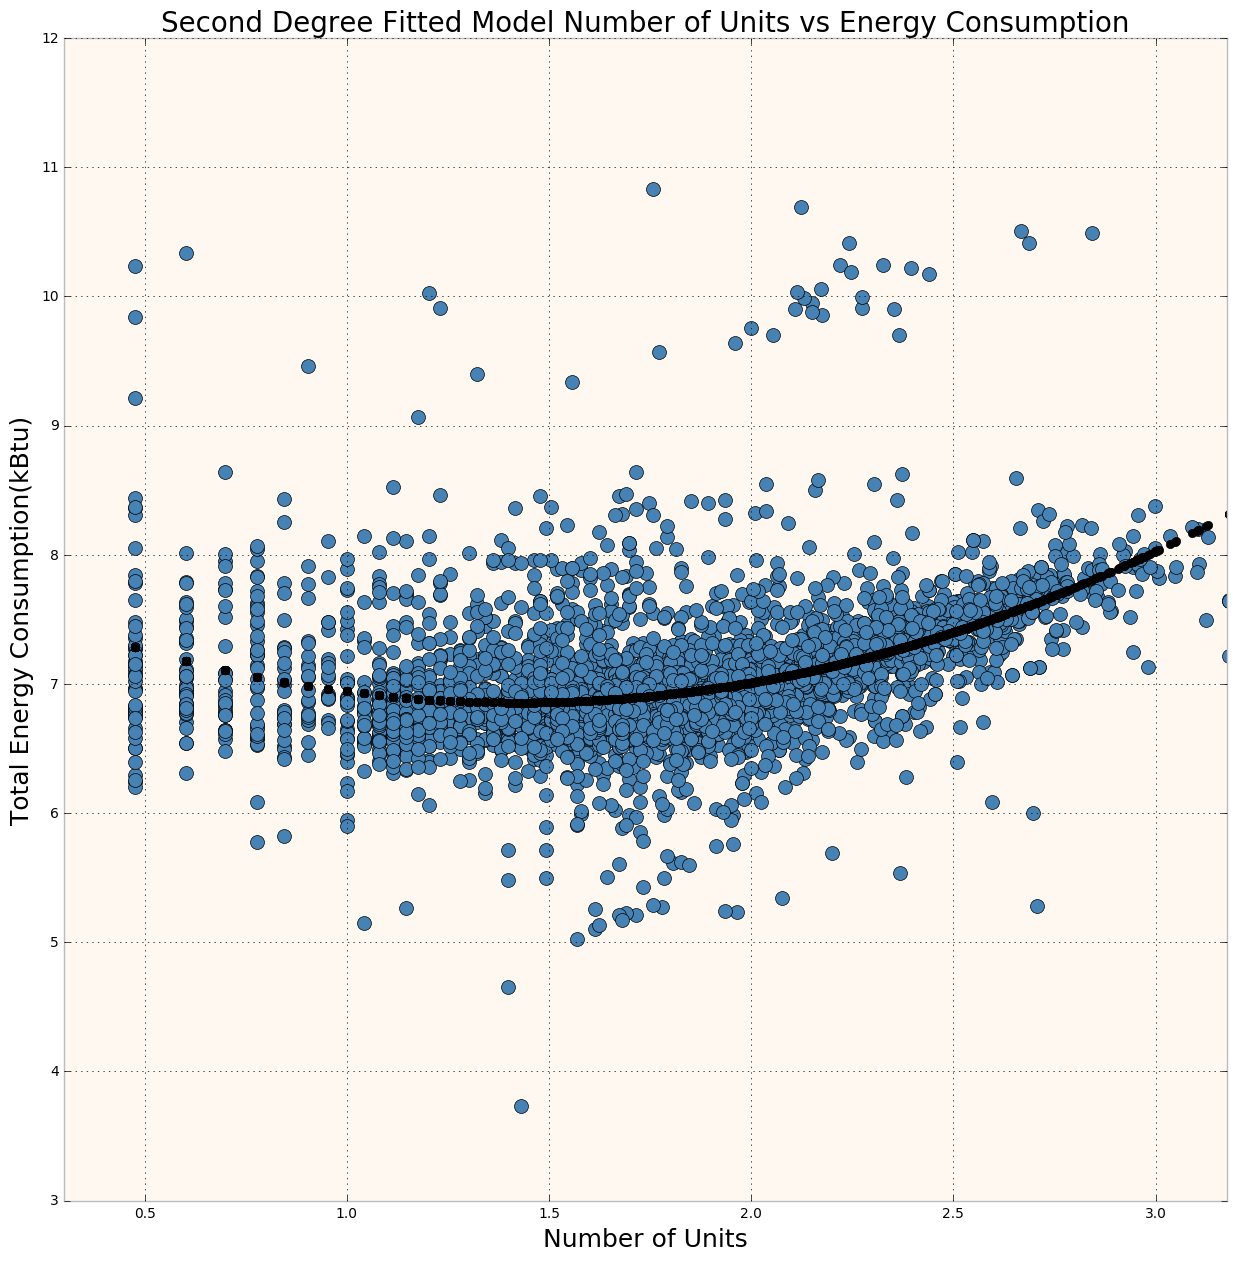

In [428]:
pl.figure(figsize = (15, 15))

pl.plot(bblclean['UnitsTotalLog'],bblclean['EnergyTotalLog'], 'o', ms = 10)
pl.plot(bblclean['UnitsTotalLog'], curvemodel.predict(bblclean),'o', color='k')
pl.title('Second Degree Fitted Model Number of Units vs Energy Consumption', size = 20)
pl.xlabel('Number of Units', size = 18)
pl.ylabel('Total Energy Consumption(kBtu)', size = 18)
plt.ylim(log10(1000), log10(1e12))
plt.xlim(log10(2), log10(1500))
pl.plot()